# Classification of Alzhaimer through Brain MRI

## Importing Libraries

In [64]:
#Package imports.
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import tensorflow as tf
import time
from keras.utils import to_categorical
from keras import layers,models,losses
from sklearn import model_selection, metrics, preprocessing
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [65]:
#Import and mount Google Drive.
from google.colab import drive
#
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Images

In [66]:
#Unzip the dataset file and store it in a folder called images.
#!unzip "/content/drive/MyDrive/MRI.zip" -d "/content/drive/MyDrive/images_MRI/"

In [67]:
!ls "/content/drive/MyDrive/images_MRI/Data"

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [68]:
#Read the images and get the data in a RGB and specific shape
folder_path = "/content/drive/MyDrive/images_MRI/Data/"
size = 128
data = []
labels = []
paths=[]
count=0
for folder in os.listdir(folder_path):
    count=0
    for files in os.listdir(os.path.join(folder_path, folder)):
        if files.endswith("jpg") and count<=487:
            count+=1
            labels.append(folder)
            #Create the image path.
            img_path = os.path.join(folder_path, folder, files)
            #Read in the images.
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            #Change BGR colour default from cv2 to RGB used in matplotlib.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resize the images.
            img = cv2.resize(img, (size, size))
            data.append(img)
            paths.append(img_path)


#Convert the data from a list to a NumPy array.
data_arr = np.array(data)

## Select by random sampling

In [69]:
#labels_np=np.array(labels)
#selected_indices={}
#classes=['Mild Dementia','Non Demented','Very mild Dementia','Moderate Dementia']
#samples=[600,2000,600,488]
#for n,t in zip(samples,classes):
#  selected_indices[t]=np.random.choice(np.where(labels_np==t)[0],n,replace=False)
#all_indices=np.hstack((selected_indices['Mild Dementia'],selected_indices['Non Demented'],selected_indices['Very mild Dementia'],selected_indices['Moderate Dementia']))
#paths_to_delete=np.setdiff1d(np.array(paths),np.array(paths)[all_indices])
#for n in paths_to_delete:
#  os.remove(n)

## Data Analysis

In [70]:
#Check the size of the images
data_arr.shape

(1952, 128, 128, 3)

In [71]:
#Check all the classes
set(labels)

{'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'}

In [72]:
#Checking number of images from Mild Dementia
print('Mild Dementia:',labels.count("Mild Dementia"))
#Checking number of images from Moderate Dementia
print('Moderate Dementia:',labels.count("Moderate Dementia"))
#Checking number of images from Non Demented
print('Non Demented:',labels.count("Non Demented"))
#Checking number of images from Very mild Dementia
print('Very mild Dementia:',labels.count("Very mild Dementia"))

Mild Dementia: 488
Moderate Dementia: 488
Non Demented: 488
Very mild Dementia: 488


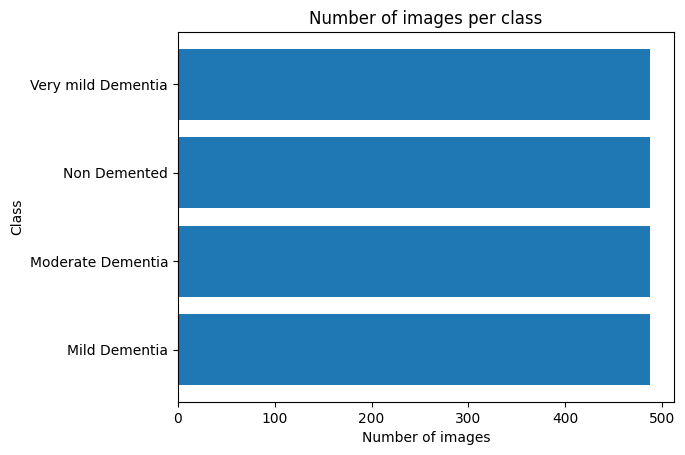

In [73]:
#Plotting horizontal barchart of the classes and images.
labels_plt=['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
count=[labels.count('Mild Dementia'),labels.count('Moderate Dementia'),labels.count('Non Demented'),labels.count('Very mild Dementia')]
fig,ax=plt.subplots()
ax.barh(labels_plt,count)
ax.set_title('Number of images per class')
ax.set_xlabel('Number of images')
ax.set_ylabel('Class')
plt.show()

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

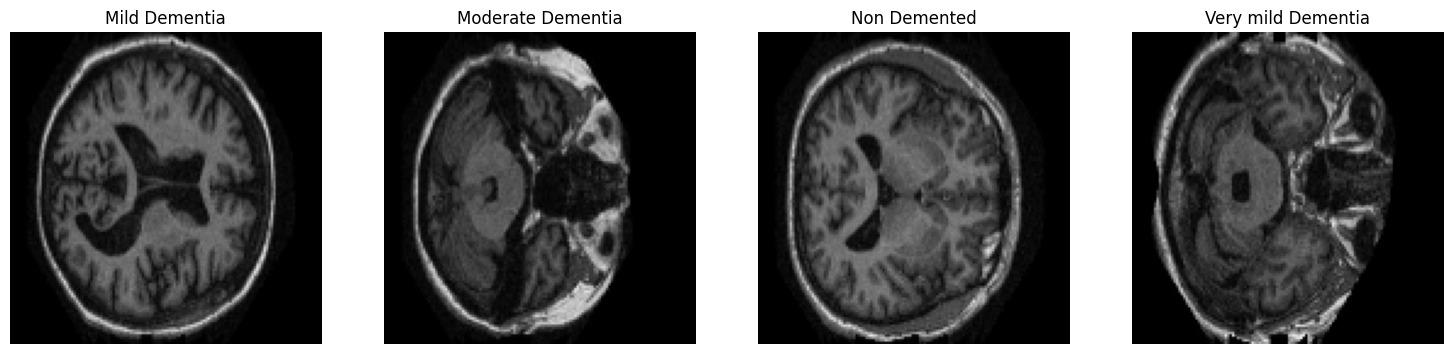

In [74]:
#Plot of examples by class of image
fig,ax=plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(data_arr[np.random.choice(range(1,450),1)[0]])
ax[0].set_title('Mild Dementia')
ax[0].axis('off')
ax[1].imshow(data_arr[np.random.choice(range(451,900),1)[0]])
ax[1].set_title('Moderate Dementia')
ax[1].axis('off')
ax[2].imshow(data_arr[np.random.choice(range(901,1350),1)[0]])
ax[2].set_title('Non Demented')
ax[2].axis('off')
ax[3].imshow(data_arr[np.random.choice(range(1351,1800),1)[0]])
ax[3].set_title('Very mild Dementia')
ax[3].axis('off')

## Preprocessing

### Create noise and data augmentation

In [75]:

#Function for create noise in the image.
def image_noise(image, noise_level):
    image = tf.cast(image, tf.int32)
    height, width, channels = image.shape[0], image.shape[1], image.shape[2]
    pixels_total = height * width * channels
    noise_added = pixels_total * noise_level
    noise_total=0
    #Get the percentage of noise
    while noise_total<noise_added:
      w=random.randint(1,3)
      h=random.randint(1,3)
      x=random.randint(1,width-w)
      y=random.randint(1,height-h)
      noise_total += w*h
      noise_to_add=w*h*3
      #Create the indices for introduce noise
      indices = [[j, k, i] for i in range(3) for j
                 in range(y, y + h) for k in range(x, x + w)]
      #Generate black noise
      noise_values = [np.random.randint(1,25)]*noise_to_add
      #Introduce noise
      image = tf.tensor_scatter_nd_update(image, indices, noise_values)
    return image

In [76]:
#Function for augment the images
def image_augment(image,seed):
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]#
    #Random left flip
    #image = tf.image.stateless_random_flip_left_right(
    #   image, seed)#
    #Random brightness change
    #image = tf.image.stateless_random_brightness(
    #    image, max_delta=0.1, seed=new_seed)
    #Introduce hue
    #image = tf.image.stateless_random_hue(
    #    image, 0.2, seed)
    #Introduce saturation
    image = tf.image.stateless_random_saturation(
        image, 0.3, 1.0, seed)
    #Adjust any value to the RGB range
    #image = tf.clip_by_value(image, 0, 255)
    return image

In [77]:
#Set the random seed generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [78]:
#Function to prepare the images with noise and augmentation
def image_wrapper(image):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  #Add noise
  image2=image_noise(image1,0.1)
  return image2/255,image1/255

In [79]:
#Function to prepare the images augmentation
def image_label_wrapper(image,label):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  return image1/255,label

In [80]:
#Function to prepare the images with noise and augmentation with label
def image_wrapper_classification(image,label):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  #Add noise
  image2=image_noise(image1,0.1)
  return image2/255,label

In [81]:
#Get dataset tensorflow type
data=tf.data.Dataset.from_tensor_slices(data_arr)

In [82]:
label_encoder=preprocessing.LabelEncoder()
label_encoder.fit(labels)
labels_encoded=label_encoder.transform(labels)
labels_encoded=to_categorical(labels_encoded)

In [83]:
#Split train and test
data_train,data_test,label_train,label_test=model_selection.train_test_split(data_arr,labels_encoded, test_size=0.1, random_state=42,stratify=labels_encoded)
data_train,data_validation,label_train,label_validation=model_selection.train_test_split(data_train,label_train, test_size=0.2, random_state=42,stratify=label_train)

In [84]:
#Preprocess the data for denoising
data_train_processed=tf.data.Dataset.from_tensor_slices(data_train).shuffle(100).map(image_wrapper).batch(32)

In [85]:
data_validation_noise=np.array([image_noise(x,0.1) for x in data_validation])
data_validation_processed=tf.data.Dataset.from_tensor_slices((data_validation_noise/255,data_validation/255)).batch(32)

data_test_noise=np.array([image_noise(x,0.1) for x in data_test])
data_test_processed=tf.data.Dataset.from_tensor_slices((data_test_noise/255,data_test/255)).batch(32)

In [86]:
data_train_classification_processed=tf.data.Dataset.from_tensor_slices((data_train,label_train)).shuffle(100).map(image_label_wrapper).batch(32)
data_validation_classification_processed=tf.data.Dataset.from_tensor_slices((data_validation/255,label_validation)).batch(32)
data_test_classification_processed=tf.data.Dataset.from_tensor_slices((data_test/255,label_test)).batch(32)

In [87]:
data_test_classification_processed=tf.data.Dataset.from_tensor_slices((data_test/255,label_test)).batch(32)

In [88]:

#Get data preprocessed
data_test_processed

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None))>

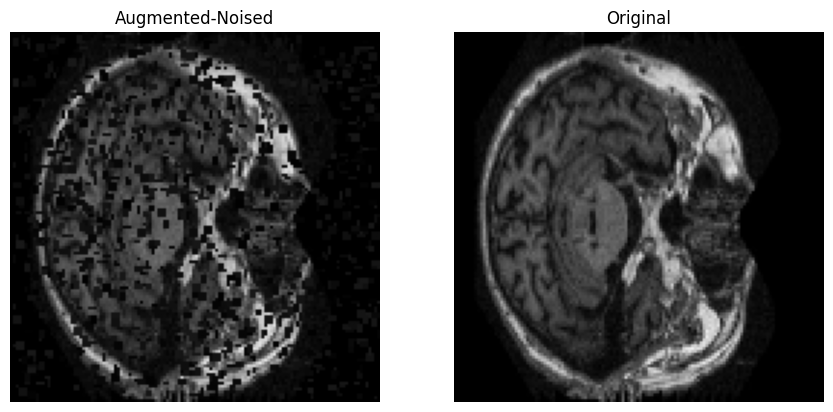

In [89]:
#Examples of
for item in data_train_processed.take(1):
    fig,ax=plt.subplots(1,2)
    fig.set_size_inches(10.5, 7.5)
    ax[0].imshow(item[0][0].numpy())
    ax[0].set_title('Augmented-Noised')
    ax[0].axis('off')
    ax[1].imshow(item[1][0].numpy())
    ax[1].set_title('Original')
    ax[1].axis('off')

In [90]:
test_original = np.asarray(list(data_test_processed.unbatch().map(lambda x, y: y)))

## Denoising

In [91]:
single_test_original=np.expand_dims(data_arr[1]/255,axis=0)
single_test_noise=np.expand_dims(image_noise(data_arr[1],0.07).numpy()/255,axis=0)

### Denoising measures

In [92]:
#Mean squared error between 2 images
def mse(image1,image2):
  mse=np.mean((image1.astype('float')-image2.astype('float'))**2)
  return mse

In [93]:
#Mean squared error between 2 groups of images
def mse_mean(image1,image2):
  mse_values=[]
  for n in range(0,image1.shape[0]):
      mse_value = mse(image1[n],image2[n])
      mse_values.append(mse_value)

  mse_mean = np.mean(mse_values)
  return mse_mean

In [94]:
#Peak signal to noise ratio between two groups of images
def psnr_mean(image1,image2):
  psnr_values=[]
  for n in range(0,image1.shape[0]):
    mse1=mse(image1[n],image2[n])
    psnr=20*np.log10(1/np.sqrt(mse1))
    psnr_values.append(psnr)
  psnr_mean = np.mean(psnr_values)
  return psnr_mean

In [95]:


#Structural similarity index between two images
def ssim_mean(image1,image2):
  ssim_values=[]
  for n in range(0,image1.shape[0]):
      ssim_value = ssim(image1[n],image2[n],channel_axis=2,data_range=image1[n].max()-image1[n].min())
      ssim_values.append(ssim_value)
  ssim_mean = np.mean(ssim_values)
  return ssim_mean

### Autoencoder

#### Model Architecture

In [ ]:
#Basic auto encoder for denoising
#Encoder 1Conv + BatchNorm + MaxPooling
def encoder(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.MaxPooling2D((2,2),padding='same')(x)
        return x
    return apply

In [ ]:
#Decoder 1ConvTrans + BatchNorm
def decoder(filters):
    def apply(x):
        x=layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [ ]:

#Auto Encoder 3Encoder + 3Decoder from 3 to 128
def autoencoder(input_shape=(128, 128, 3)):
    inputs=layers.Input(shape=input_shape)
    #Encoder
    x=encoder(32)(inputs)
    x=encoder(64)(x)
    x=encoder(128)(x)
    #Decoder
    x=decoder(128)(x)
    x=decoder(64)(x)
    x=decoder(32)(x)
    outputs=layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [ ]:
#Define autoencoder and see the structure
ae=autoencoder()
ae.save_weights('ae_initial_model_weights.weights.h5')
ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 3)         │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,979 (1.28 MB)

 Trainable params: 334,083 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
#Compile model with adam and mean squared error
ae.compile(optimizer='adam',loss='mse')

#### Model Train and Test with Hyperparameters

In [ ]:
learning_rates=[1e-3,1e-4,1e-5]

In [ ]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,verbose=1,restore_best_weights=True,min_delta=0.0001)

In [ ]:
loss_ae=[]
time_ae=[]
loss_ae_train=[]
for n,l in enumerate(learning_rates):
  start_time=time.time()
  checkpoint=ModelCheckpoint('/content/drive/MyDrive/images_MRI/ae_weights_{l}.keras'.format(l=n), monitor='val_loss', save_best_only=True, verbose=1)
  ae.load_weights('ae_initial_model_weights.weights.h5')
  ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l),loss='mse')
  ae_history=ae.fit(data_train_processed,epochs=30,validation_data=data_validation_processed,callbacks=[reduce_lr,checkpoint])
  loss_ae.append(ae_history.history['val_loss'])
  loss_ae_train.append(ae_history.history['loss'])
  total_time=time.time()-start_time
  time_ae.append(total_time)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 0.1268
Epoch 1: val_loss improved from inf to 0.07393, saving model to /content/drive/MyDrive/images_MRI/ae_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 588ms/step - loss: 0.1261 - val_loss: 0.0739 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.0530
Epoch 2: val_loss improved from 0.07393 to 0.03599, saving model to /content/drive/MyDrive/images_MRI/ae_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - loss: 0.0528 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - loss: 0.0307
Epoch 3: val_loss improved from 0.03599 to 0.02961, saving model to /content/drive/MyDrive/images_MRI/ae_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - loss: 0.0306 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.0186
Epoch 4: val_loss did not improve from 0.02961
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 54 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 0.1786
Epoch 1: val_loss improved from inf to 0.13842, saving model to /content/drive/MyDrive/images_MRI/ae_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 490ms/step - loss: 0.1782 - val_loss: 0.1384 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.1178
Epoch 2: val_loss improved from 0.13842 to 0.11644, saving model to /content/drive/MyDrive/images_MRI/ae_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 384ms/step - loss: 0.1177 - val_loss: 0.1164 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.0980
Epoch 3: val_loss improved from 0.11644 to 0.09623, saving model to /content/drive/MyDrive/images_MRI/ae_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 416ms/step - loss: 0.0980 - val_loss: 0.0962 - learning_rate: 1.0000e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.0866
Epoch 4: val_loss improved from 0.09623 to 0.07901, saving model to /con

Learning rate: 0.001


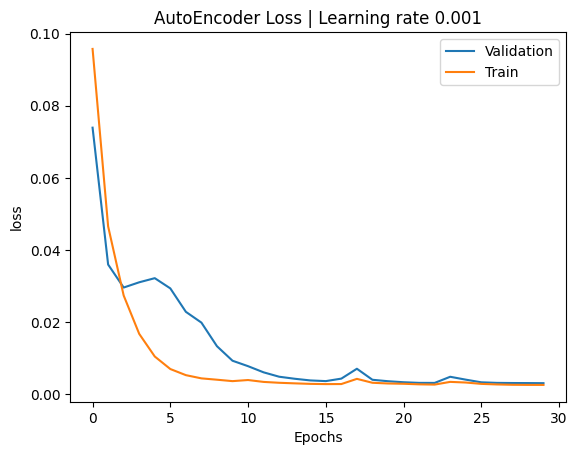

Learning rate: 0.0001


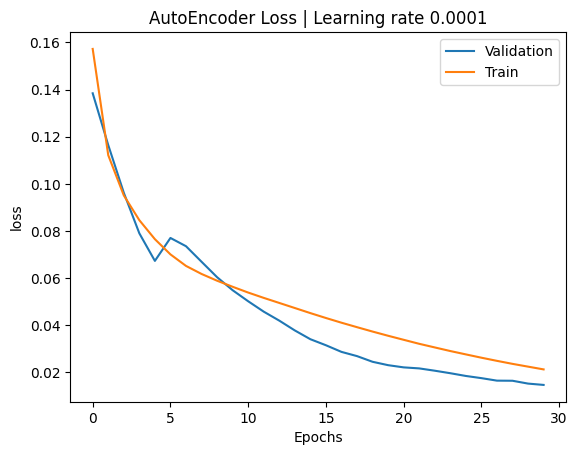

Learning rate: 1e-05


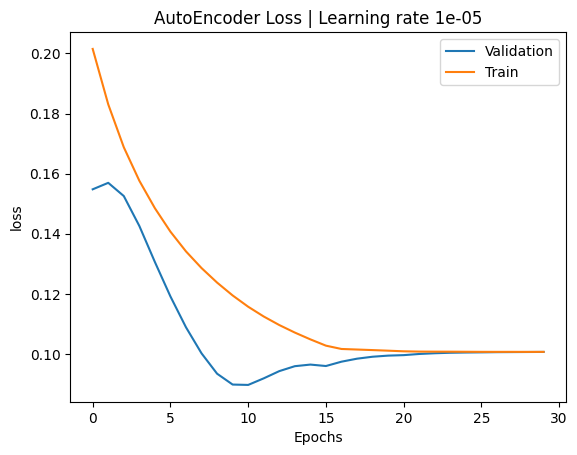

In [ ]:
for n,l in enumerate(learning_rates):
  print('Learning rate:',l)
  plt.plot(loss_ae[n],label='Validation')
  plt.plot(loss_ae_train[n],label='Train')
  plt.title('AutoEncoder Loss | Learning rate {f}'.format(f=l))
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [ ]:
for l in learning_rates:
  ae.load_weights('/content/drive/MyDrive/images_MRI/ae_weights_{l}.keras'.format(l=learning_rates.index(l)))
  print('/content/drive/MyDrive/images_MRI/ae_weights_{l}.keras'.format(l=learning_rates.index(l)))
  ae_predicted=ae.predict(data_test_processed)
  ae_mse=mse_mean(test_original,ae_predicted)
  ae_psnr=psnr_mean(test_original,ae_predicted)
  ae_ssim=ssim_mean(test_original,ae_predicted)
  print('Learning rate:',l)
  print('MSE:',round(ae_mse,3))
  print('PSNR:',round(ae_psnr,3))
  print('SSIM:',round(ae_ssim,3))
  print('Learning rate:',l)
  print('Time:',round(time_ae[learning_rates.index(l)],2))

/content/drive/MyDrive/images_MRI/ae_weights_0.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step
Learning rate: 0.001
MSE: 0.003
PSNR: 25.019
SSIM: 0.681
Learning rate: 0.001
Time: 605.91
/content/drive/MyDrive/images_MRI/ae_weights_1.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Learning rate: 0.0001
MSE: 0.015
PSNR: 18.381
SSIM: 0.337
Learning rate: 0.0001
Time: 611.74
/content/drive/MyDrive/images_MRI/ae_weights_2.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Learning rate: 1e-05
MSE: 0.089
PSNR: 10.508
SSIM: 0.063
Learning rate: 1e-05
Time: 596.46


#### Test

In [ ]:
ae.load_weights('/content/drive/MyDrive/images_MRI/ae_weights_0.keras')

In [ ]:
single_ae_predicted=ae.predict(single_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

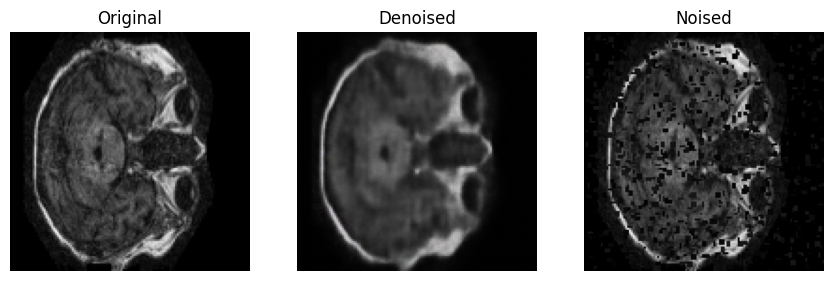

In [ ]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(single_ae_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

In [ ]:
ae_predicted=ae.predict(data_test_processed)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [ ]:
ae_mse=mse_mean(test_original,ae_predicted)
ae_psnr=psnr_mean(test_original,ae_predicted)
ae_ssim=ssim_mean(test_original,ae_predicted)
print('MSE:',round(ae_mse,3))
print('PSNR:',round(ae_psnr,3))
print('SSIM:',round(ae_ssim,3))

MSE: 0.003
PSNR: 25.019
SSIM: 0.681


### U-Net

#### Model Architecture

In [ ]:
#U-Net for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet_double_conv(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [ ]:
#U-Net encoder 1MaxPooling + 1DoubleConv
def unet_encoder(filters):
    def apply(x):
        x=layers.MaxPooling2D((2,2))(x)
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [ ]:
#U-Net decoder 1ConvTrans + 1Concatenate +1DoubleConv
def unet_decoder(filters):
    def apply(x, skip):
        x=layers.Conv2DTranspose(filters,(3,3),activation='relu',strides=2,padding='same')(x)
        x=layers.Concatenate()([x, skip])
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [ ]:
#U-Net from 3 to 1024 with MaxPooling
def unet(input_shape=(128, 128, 3)):
    input = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet_double_conv(64)(input)
    x2 = unet_encoder(128)(x1)
    x3 = unet_encoder(256)(x2)
    x4 = unet_encoder(512)(x3)
    x  = unet_encoder(1024)(x4)
    #Decoder feom 512 to 3
    x = unet_decoder(512)(x, x4)
    x = unet_decoder(256)(x, x3)
    x = unet_decoder(128)(x, x2)
    x = unet_decoder(64)(x, x1)
    output = layers.Conv2D(3,(1,1),activation='sigmoid')(x)
    return models.Model(input,output)

In [ ]:
unet=unet()
unet.save_weights('unet_initial_model_weights.weights.h5')
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32, 32, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 34,537,027 (131.75 MB)

 Trainable params: 34,525,251 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
#Compile the unet with adam and mse
unet.compile(optimizer='adam',loss='mse')

#### Model Train and Test with Hyperparameters

In [ ]:
learning_rates=[1e-3,1e-4,1e-5]

In [ ]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,verbose=1,restore_best_weights=True,min_delta=0.0001)

In [ ]:
loss_unet=[]
time_unet=[]
loss_unet_train=[]
for n,l in enumerate(learning_rates):
  start_time=time.time()
  checkpoint=ModelCheckpoint('/content/drive/MyDrive/images_MRI/unet_weights_{l}.keras'.format(l=n), monitor='val_loss', save_best_only=True, verbose=1)
  unet.load_weights('unet_initial_model_weights.weights.h5')
  unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l),loss='mse')
  unet_history=unet.fit(data_train_processed,epochs=30,validation_data=data_validation_processed,callbacks=[reduce_lr,checkpoint])
  loss_unet.append(unet_history.history['val_loss'])
  loss_unet_train.append(unet_history.history['loss'])
  total_time=time.time()-start_time
  time_unet.append(total_time)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0953   
Epoch 1: val_loss improved from inf to 0.08173, saving model to /content/drive/MyDrive/images_MRI/unet_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - loss: 0.0946 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - loss: 0.0281
Epoch 2: val_loss improved from 0.08173 to 0.03453, saving model to /content/drive/MyDrive/images_MRI/unet_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 916ms/step - loss: 0.0280 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - loss: 0.0132
Epoch 3: val_loss did not improve from 0.03453
44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 846ms/step - loss: 0.0132 - val_loss: 0.0419 - learning_rate: 0.0010
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - loss: 0.0072
Epoch 4: val_loss did not improve from 0.03453
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 820ms/step - loss: 0.0072 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 5/3

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 166 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - loss: 0.1368
Epoch 1: val_loss improved from inf to 0.10650, saving model to /content/drive/MyDrive/images_MRI/unet_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 0.1363 - val_loss: 0.1065 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - loss: 0.0762
Epoch 2: val_loss improved from 0.10650 to 0.05961, saving model to /content/drive/MyDrive/images_MRI/unet_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 929ms/step - loss: 0.0761 - val_loss: 0.0596 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - loss: 0.0584
Epoch 3: val_loss improved from 0.05961 to 0.04158, saving model to /content/drive/MyDrive/images_MRI/unet_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 904ms/step - loss: 0.0583 - val_loss: 0.0416 - learning_rate: 1.0000e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - loss: 0.0492
Epoch 4: val_loss improved from 0.04158 to 0.03272, saving model to /

Learning rate: 0.001


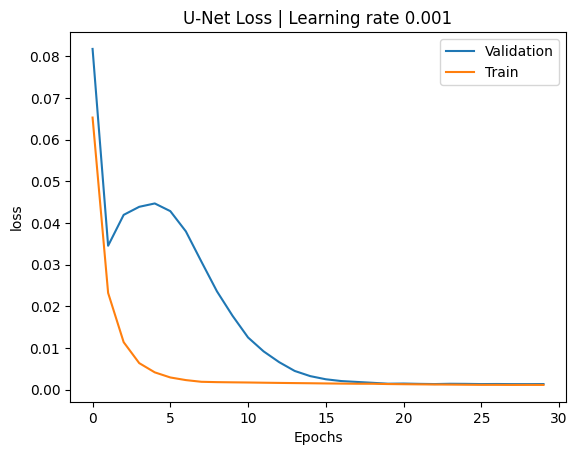

Learning rate: 0.0001


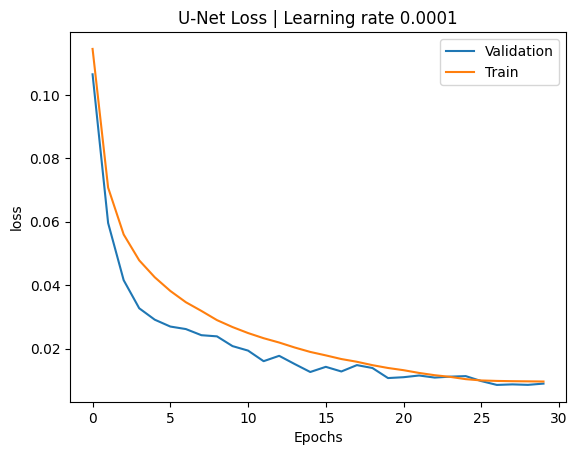

Learning rate: 1e-05


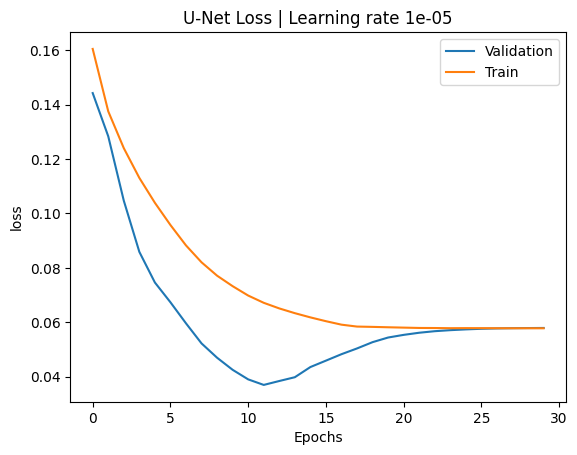

In [ ]:
for n,l in enumerate(learning_rates):
  print('Learning rate:',l)
  plt.plot(loss_unet[n],label='Validation')
  plt.plot(loss_unet_train[n],label='Train')
  plt.title('U-Net Loss | Learning rate {f}'.format(f=l))
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [ ]:
for l in learning_rates:
  unet.load_weights('/content/drive/MyDrive/images_MRI/unet_weights_{l}.keras'.format(l=learning_rates.index(l)))
  unet_predicted=unet.predict(data_test_processed)
  unet_mse=mse_mean(test_original,unet_predicted)
  unet_psnr=psnr_mean(test_original,unet_predicted)
  unet_ssim=ssim_mean(test_original,unet_predicted)
  print('Learning rate:',l)
  print('MSE:',round(unet_mse,3))
  print('PSNR:',round(unet_psnr,3))
  print('SSIM:',round(unet_ssim,3))
  print('Learning rate:',l)
  print('Time:',round(time_unet[learning_rates.index(l)],2))

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Learning rate: 0.001
MSE: 0.001
PSNR: 28.835
SSIM: 0.736
Learning rate: 0.001
Time: 1478.36
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
Learning rate: 0.0001
MSE: 0.009
PSNR: 20.941
SSIM: 0.597
Learning rate: 0.0001
Time: 1328.13
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Learning rate: 1e-05
MSE: 0.037
PSNR: 14.333
SSIM: 0.328
Learning rate: 1e-05
Time: 1444.77


#### Test

In [ ]:
unet.load_weights('/content/drive/MyDrive/images_MRI/unet_weights_0.keras')

In [ ]:
single_unet_predicted=unet.predict(single_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

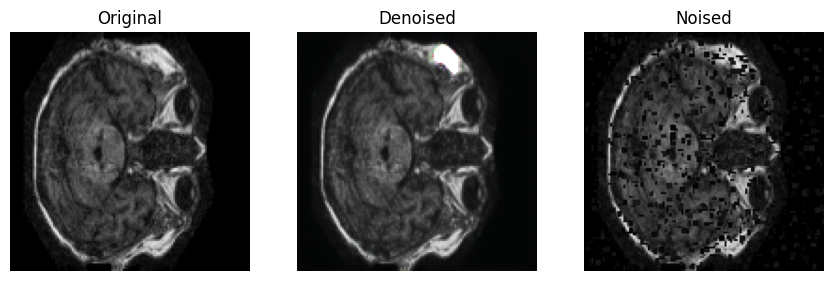

In [ ]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(single_unet_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

In [ ]:
unet_predicted=unet.predict(data_test_processed)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


In [ ]:
unet_mse=mse_mean(test_original,unet_predicted)
unet_psnr=psnr_mean(test_original,unet_predicted)
unet_ssim=ssim_mean(test_original,unet_predicted)
print('MSE:',round(unet_mse,3))
print('PSNR:',round(unet_psnr,3))
print('SSIM:',round(unet_ssim,3))

MSE: 0.001
PSNR: 28.835
SSIM: 0.736



### U-Net Residual (Upsampling)

#### Model Architecture

In [96]:
def unet_conv_res(filters):
    def apply(x):
        conv = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(conv)
        conv = layers.BatchNormalization()(conv)

        shortcut=layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
        shortcut = layers.BatchNormalization()(shortcut)

        res = layers.Add()([shortcut, conv])
        res = layers.Activation('relu')(res)
        return res
    return apply

In [97]:
#U-Net with updampling for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet2_conv(filters):
    def apply(x):
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x
    return apply

In [98]:
#Unet encoder with 1MaxPoolin and +1DoubleConv
def unet_encoder_res(filters):
    def apply(x):
        x = layers.MaxPooling2D((2,2))(x)
        x = unet_conv_res(filters)(x)
        return x
    return apply

In [99]:
#Unet decoder with 1Upsampling + 1ConvTrans +1Concat + 1DoubleConv
def unet_decoder_res(filters):
    def apply(x, skip):
        x = layers.UpSampling2D((2,2))(x)
        x = layers.Conv2DTranspose(filters, (1,1), activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = unet_conv_res(filters)(x)
        return x
    return apply

In [100]:
#U-Net from 3 to 1024 with Upsampling
def unet_res(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet_conv_res(64)(inputs)
    x2 = unet_encoder_res(128)(x1)
    x3 = unet_encoder_res(256)(x2)
    x4 = unet_encoder_res(512)(x3)
    x  = unet_encoder_res(1024)(x4)
    #Decoder from 512 to 3
    x = unet_decoder_res(512)(x, x4)
    x = unet_decoder_res(256)(x, x3)
    x = unet_decoder_res(128)(x, x2)
    x = unet_decoder_res(64)(x, x1)
    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [101]:
#U-Net with Upsampling model with summary
unet_res = unet_res()
unet_res.save_weights('unet_res_initial_model_weights.weights.h5')
unet_res.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 128, 128,  │        256 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 128, 128,  │          0 │ add_9[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │      8,320 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 30,374,019 (115.87 MB)

 Trainable params: 30,356,355 (115.80 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [102]:
#U-Net with upsampling compile with adam and mse
unet_res.compile(optimizer='adam',loss='mse')

#### Model Train and Test with Hyperparameters

In [ ]:
learning_rates=[1e-3,1e-4,1e-5]

In [ ]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,verbose=1,restore_best_weights=True,min_delta=0.0001)

In [ ]:
loss_unet_res=[]
time_unet_res=[]
loss_unet_res_train=[]
for n,l in enumerate(learning_rates):
  start_time=time.time()
  checkpoint=ModelCheckpoint('/content/drive/MyDrive/images_MRI/unet_res_weights_{l}.keras'.format(l=n), monitor='val_loss', save_best_only=True, verbose=1)
  unet_res.load_weights('unet_res_initial_model_weights.weights.h5')
  unet_res.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l),loss='mse')
  unet_res_history=unet_res.fit(data_train_processed,epochs=30,validation_data=data_validation_processed,callbacks=[reduce_lr,checkpoint])
  loss_unet_res.append(unet_res_history.history['val_loss'])
  loss_unet_res_train.append(unet_res_history.history['loss'])
  total_time=time.time()-start_time
  time_unet_res.append(total_time)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0495   
Epoch 1: val_loss improved from inf to 0.25063, saving model to /content/drive/MyDrive/images_MRI/unet_res_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - loss: 0.0488 - val_loss: 0.2506 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - loss: 0.0024
Epoch 2: val_loss improved from 0.25063 to 0.03535, saving model to /content/drive/MyDrive/images_MRI/unet_res_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 57s 907ms/step - loss: 0.0024 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - loss: 0.0018
Epoch 3: val_loss improved from 0.03535 to 0.02831, saving model to /content/drive/MyDrive/images_MRI/unet_res_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 901ms/step - loss: 0.0018 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - loss: 0.0016
Epoch 4: val_loss improved from 0.02831 to 0.02702, saving model to 

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 238 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1090   
Epoch 1: val_loss improved from inf to 0.08190, saving model to /content/drive/MyDrive/images_MRI/unet_res_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - loss: 0.1081 - val_loss: 0.0819 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - loss: 0.0167
Epoch 2: val_loss improved from 0.08190 to 0.04330, saving model to /content/drive/MyDrive/images_MRI/unet_res_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 922ms/step - loss: 0.0166 - val_loss: 0.0433 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - loss: 0.0066
Epoch 3: val_loss improved from 0.04330 to 0.03227, saving model to /content/drive/MyDrive/images_MRI/unet_res_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 929ms/step - loss: 0.0066 - val_loss: 0.0323 - learning_rate: 1.0000e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - loss: 0.0047
Epoch 4: val_loss improved from 0.03227 to 0.03138, savin

Learning rate: 0.001


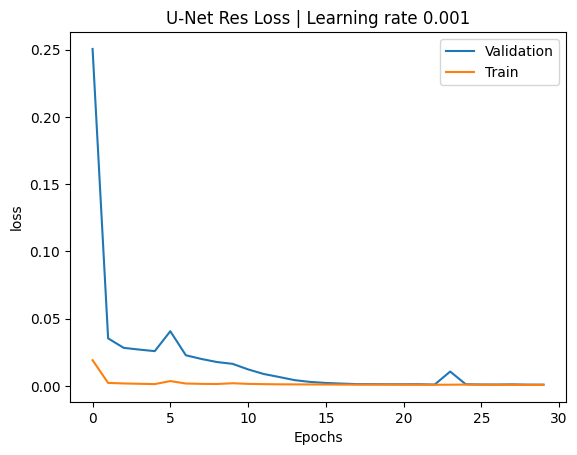

Learning rate: 0.0001


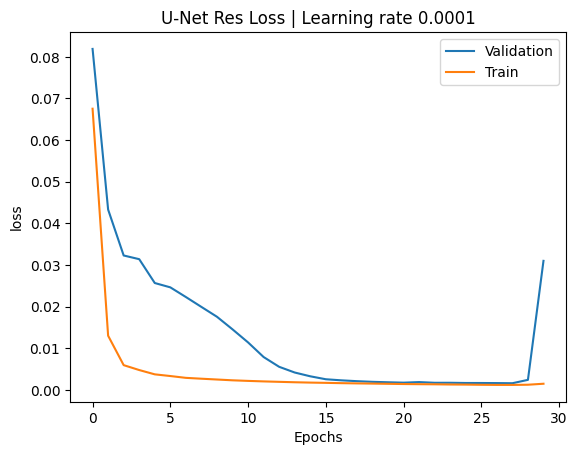

Learning rate: 1e-05


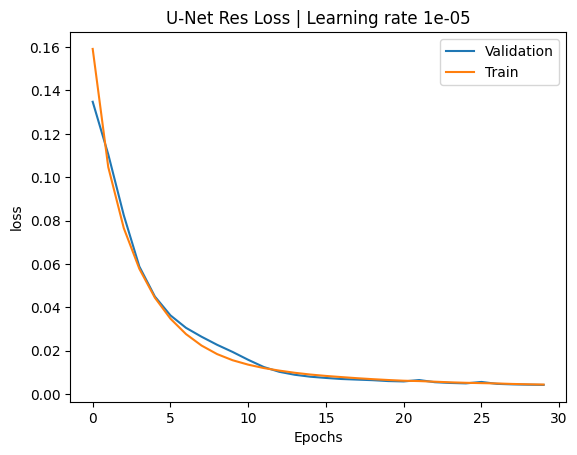

In [ ]:
for n,l in enumerate(learning_rates):
  print('Learning rate:',l)
  plt.plot(loss_unet_res[n],label='Validation')
  plt.plot(loss_unet_res_train[n],label='Train')
  plt.title('U-Net Res Loss | Learning rate {f}'.format(f=l))
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [ ]:
for l in learning_rates:
  unet_res.load_weights('/content/drive/MyDrive/images_MRI/unet_res_weights_{l}.keras'.format(l=learning_rates.index(l)))
  unet_res_predicted=unet_res.predict(data_test_processed)
  unet_res_mse=mse_mean(test_original,unet_res_predicted)
  unet_res_psnr=psnr_mean(test_original,unet_res_predicted)
  unet_res_ssim=ssim_mean(test_original,unet_res_predicted)
  print('Learning rate:',l)
  print('MSE:',round(unet_res_mse,3))
  print('PSNR:',round(unet_res_psnr,3))
  print('SSIM:',round(unet_res_ssim,3))
  print('Learning rate:',l)
  print('Time:',round(time_unet_res[learning_rates.index(l)],2))

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Learning rate: 0.001
MSE: 0.001
PSNR: 30.21
SSIM: 0.922
Learning rate: 0.001
Time: 1568.72
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Learning rate: 0.0001
MSE: 0.002
PSNR: 27.985
SSIM: 0.782
Learning rate: 0.0001
Time: 1579.56
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
Learning rate: 1e-05
MSE: 0.004
PSNR: 23.744
SSIM: 0.566
Learning rate: 1e-05
Time: 1879.81


#### Test

In [ ]:
unet_res.load_weights('/content/drive/MyDrive/images_MRI/unet_res_weights_0.keras')

In [ ]:
single_unet_res_predicted=unet_res.predict(single_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

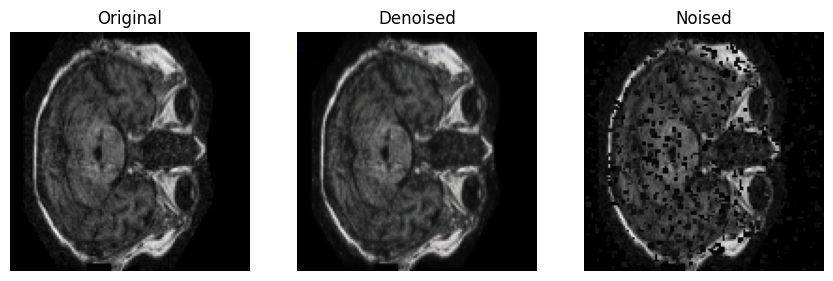

In [ ]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(single_unet_res_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

In [ ]:
unet_res_predicted=unet_res.predict(data_test_processed)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


In [ ]:
unet_res_mse=mse_mean(test_original,unet_res_predicted)
unet_res_psnr=psnr_mean(test_original,unet_res_predicted)
unet_res_ssim=ssim_mean(test_original,unet_res_predicted)
print('MSE:',round(unet_res_mse,3))
print('PSNR:',round(unet_res_psnr,3))
print('SSIM:',round(unet_res_ssim,3))

MSE: 0.001
PSNR: 30.21
SSIM: 0.922


## Classification

### Transfer learning ResNet50

#### Architecture

In [38]:
res_model=tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(128,128,3),pooling='avg')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [40]:
res_model.trainable=False

In [41]:
res_transfer=tf.keras.Sequential([
    res_model,
    layers.BatchNormalization(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4,activation='softmax')
])

res_transfer.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,153,860 (92.14 MB)

 Trainable params: 562,052 (2.14 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [42]:
res_transfer.save_weights('res_transfer_initial_model_weights.weights.h5')

#### Model Train and Test with Hyperparameters

In [43]:
learning_rates=[1e-3,1e-4,1e-5]

In [44]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,verbose=1,restore_best_weights=True,min_delta=0.0001)

In [48]:
loss_res_transfer=[]
accuracy_res_transfer=[]
precision_res_transfer=[]
recall_res_transfer=[]
time_res_transfer=[]

loss_res_transfer_train=[]
accuracy_res_transfer_train=[]
precision_res_transfer_train=[]
recall_res_transfer_train=[]
for n,l in enumerate(learning_rates):
  start_time=time.time()
  checkpoint=ModelCheckpoint('/content/drive/MyDrive/images_MRI/res_transfer_weights_{l}.keras'.format(l=n), monitor='val_loss', save_best_only=True, verbose=1)
  res_transfer.load_weights('res_transfer_initial_model_weights.weights.h5')
  res_transfer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l),loss='categorical_crossentropy',metrics=['accuracy','precision','recall'])
  res_transfer_history=res_transfer.fit(data_train_classification_processed,epochs=30,validation_data=data_validation_classification_processed,callbacks=[reduce_lr,checkpoint])
  loss_res_transfer.append(res_transfer_history.history['val_loss'])
  accuracy_res_transfer.append(res_transfer_history.history['val_accuracy'])
  precision_res_transfer.append(res_transfer_history.history['val_precision'])
  recall_res_transfer.append(res_transfer_history.history['val_recall'])
  loss_res_transfer_train.append(res_transfer_history.history['loss'])
  accuracy_res_transfer_train.append(res_transfer_history.history['accuracy'])
  precision_res_transfer_train.append(res_transfer_history.history['precision'])
  recall_res_transfer_train.append(res_transfer_history.history['recall'])
  total_time=time.time()-start_time
  time_res_transfer.append(total_time)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.4386 - loss: 1.2045 - precision: 0.6353 - recall: 0.1175
Epoch 1: val_loss improved from inf to 1.61724, saving model to /content/drive/MyDrive/images_MRI/res_transfer_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - accuracy: 0.4409 - loss: 1.2013 - precision: 0.6380 - recall: 0.1205 - val_accuracy: 0.2472 - val_loss: 1.6172 - val_precision: 0.6579 - val_recall: 0.0710 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7219 - loss: 0.7460 - precision: 0.7933 - recall: 0.5721
Epoch 2: val_loss did not improve from 1.61724
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7221 - loss: 0.7451 - precision: 0.7937 - recall: 0.5728 - val_accuracy: 0.2869 - val_loss: 2.0052 - val_precision: 0.3040 - val_recall: 0.2358 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7814 - loss: 0.5758 - precision: 0.8365 - recall: 0.7023
Epoch 3: val_loss did no

Learning rate: 0.001
Time: 147.84


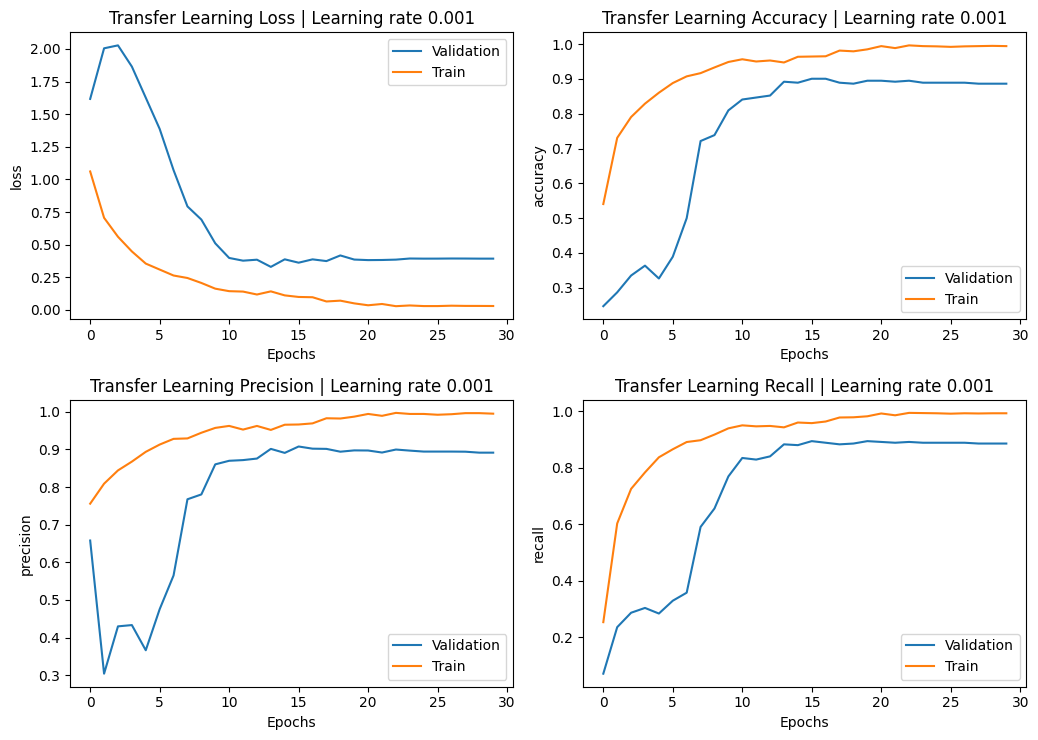

Learning rate: 0.0001
Time: 159.39


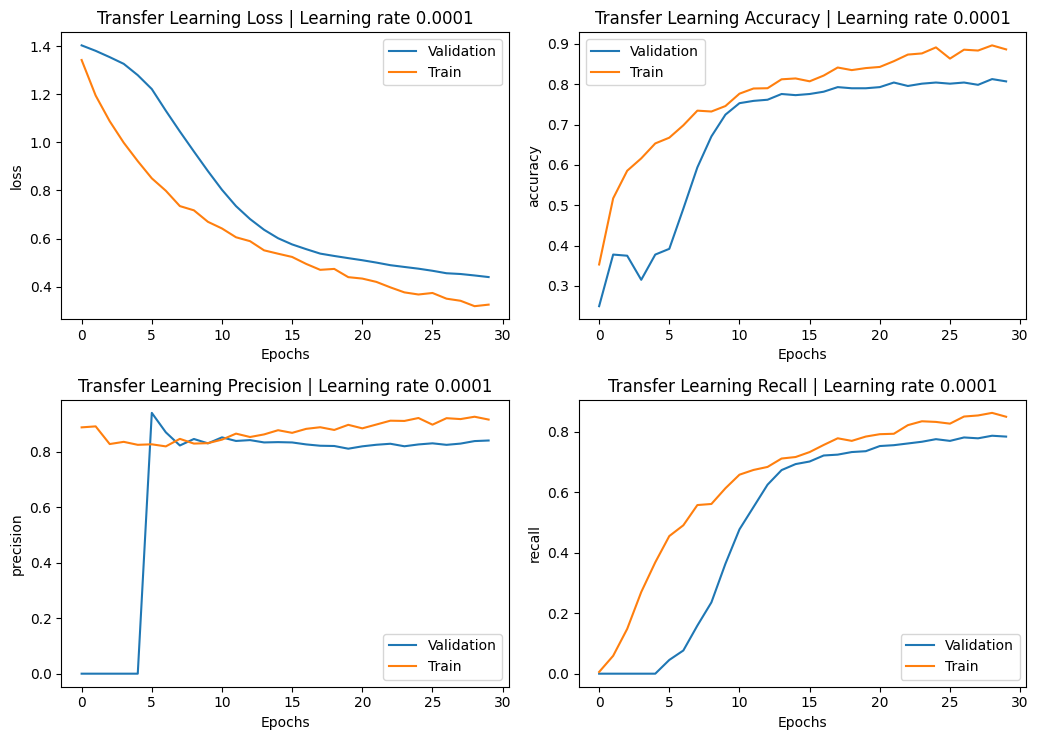

Learning rate: 1e-05
Time: 163.99


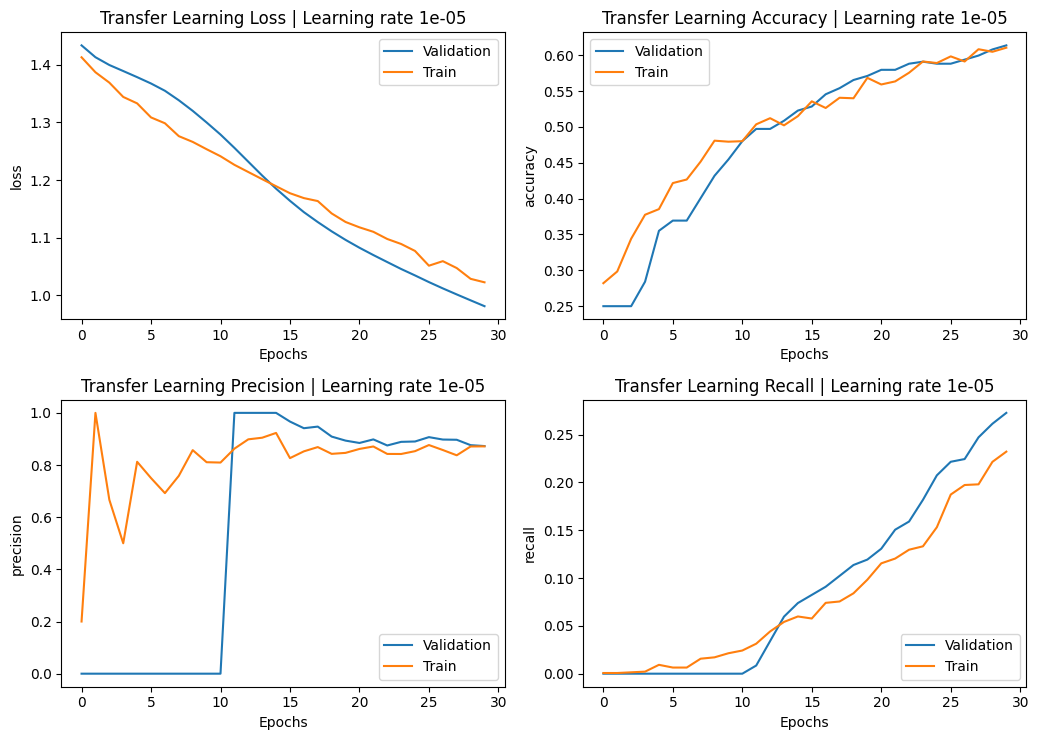

In [49]:
for n,l in enumerate(learning_rates):
  print('Learning rate:',l)
  print('Time:',round(time_res_transfer[n],2))
  fig,ax=plt.subplots(2,2)
  fig.set_size_inches(10.5, 7.5)
  ax=ax.flatten()
  ax[0].plot(loss_res_transfer[n],label='Validation')
  ax[0].plot(loss_res_transfer_train[n],label='Train')
  ax[0].set_title('Transfer Learning Loss | Learning rate {f}'.format(f=l))
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('loss')
  ax[0].legend()

  ax[1].plot(accuracy_res_transfer[n],label='Validation')
  ax[1].plot(accuracy_res_transfer_train[n],label='Train')
  ax[1].set_title('Transfer Learning Accuracy | Learning rate {f}'.format(f=l))
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()

  ax[2].plot(precision_res_transfer[n],label='Validation')
  ax[2].plot(precision_res_transfer_train[n],label='Train')
  ax[2].set_title('Transfer Learning Precision | Learning rate {f}'.format(f=l))
  ax[2].set_xlabel('Epochs')
  ax[2].set_ylabel('precision')
  ax[2].legend()

  ax[3].plot(recall_res_transfer[n],label='Validation')
  ax[3].plot(recall_res_transfer_train[n],label='Train')
  ax[3].set_title('Transfer Learning Recall | Learning rate {f}'.format(f=l))
  ax[3].set_xlabel('Epochs')
  ax[3].set_ylabel('recall')
  ax[3].legend()

  plt.tight_layout()
  plt.legend(loc='lower right')
  plt.show()

Learning rate: 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 904ms/step


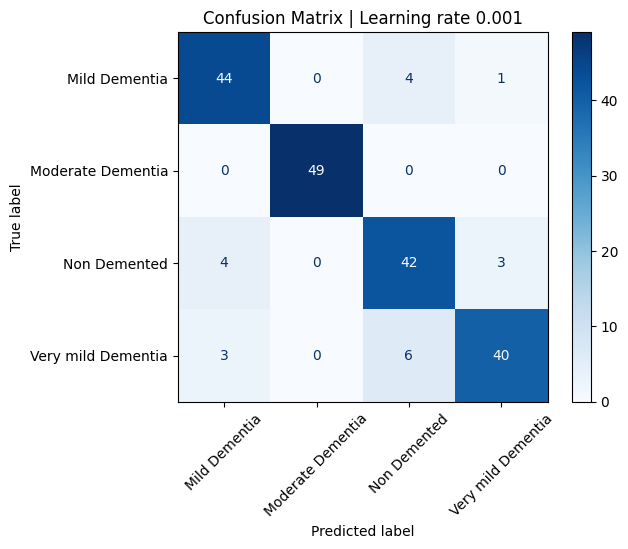

                    precision    recall  f1-score   support

     Mild Dementia       0.86      0.90      0.88        49
 Moderate Dementia       1.00      1.00      1.00        49
      Non Demented       0.81      0.86      0.83        49
Very mild Dementia       0.91      0.82      0.86        49

          accuracy                           0.89       196
         macro avg       0.89      0.89      0.89       196
      weighted avg       0.89      0.89      0.89       196

Learning rate: 0.0001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


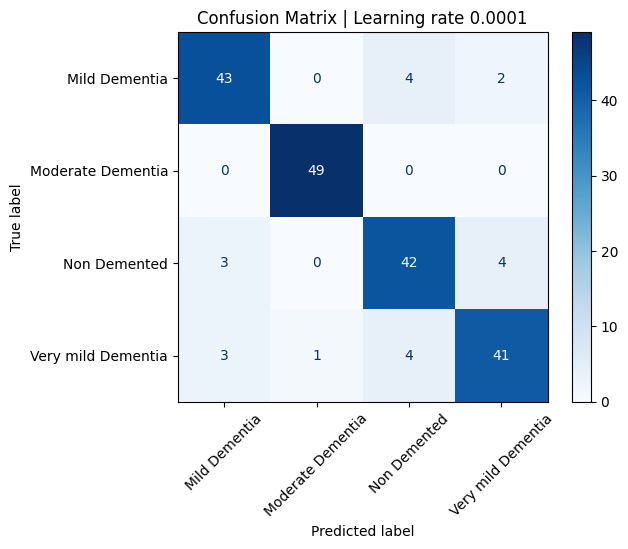

                    precision    recall  f1-score   support

     Mild Dementia       0.88      0.88      0.88        49
 Moderate Dementia       0.98      1.00      0.99        49
      Non Demented       0.84      0.86      0.85        49
Very mild Dementia       0.87      0.84      0.85        49

          accuracy                           0.89       196
         macro avg       0.89      0.89      0.89       196
      weighted avg       0.89      0.89      0.89       196

Learning rate: 1e-05
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


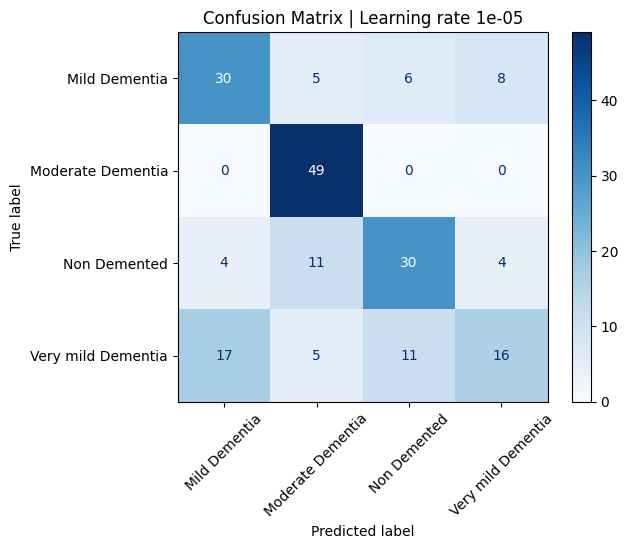

                    precision    recall  f1-score   support

     Mild Dementia       0.59      0.61      0.60        49
 Moderate Dementia       0.70      1.00      0.82        49
      Non Demented       0.64      0.61      0.62        49
Very mild Dementia       0.57      0.33      0.42        49

          accuracy                           0.64       196
         macro avg       0.62      0.64      0.62       196
      weighted avg       0.62      0.64      0.62       196



In [47]:
for n,i in enumerate(learning_rates):
  print('Learning rate:',i)
  res_transfer.load_weights('/content/drive/MyDrive/images_MRI/res_transfer_weights_{l}.keras'.format(l=n))
  res_predicted=res_transfer.predict(data_test/255)
  res_predicted=np.argmax(res_predicted,axis=1)
  cm=confusion_matrix(np.argmax(label_test,axis=1),res_predicted)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('ResNet50 | Learning rate {f}'.format(f=i))
  plt.xticks(rotation=45)
  plt.show()
  print(classification_report(np.argmax(label_test,axis=1),res_predicted,target_names=label_encoder.classes_))

### Custom CNN

#### Model architecture

In [103]:
def cnn_double_conv(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [104]:
def cnn(input_shape=(128, 128, 3)):
    inputs=layers.Input(shape=input_shape)
    cn1=cnn_double_conv(32)(inputs)
    mp1=layers.MaxPooling2D((2,2))(cn1)
    dp1=layers.Dropout(0.25)(mp1)

    cn2=cnn_double_conv(64)(dp1)
    mp2=layers.MaxPooling2D((2,2))(cn2)
    dp2=layers.Dropout(0.25)(mp2)

    cn3=cnn_double_conv(128)(dp2)
    mp3=layers.MaxPooling2D((2,2))(cn3)
    dp3=layers.Dropout(0.25)(mp3)

    x=layers.Flatten()(dp3)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dropout(0.2)(x)

    outputs=layers.Dense(4,activation='softmax')(x)
    return models.Model(inputs, outputs)

In [105]:
custom_cnn=cnn()
custom_cnn.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             

 Total params: 8,678,692 (33.11 MB)

 Trainable params: 8,677,796 (33.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [106]:
custom_cnn.save_weights('custom_cnn_initial_model_weights.weights.h5')

#### Model Train and Test with Hyperparameters

In [35]:
learning_rates=[1e-3,1e-4,1e-5]

In [36]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,verbose=1,restore_best_weights=True,min_delta=0.0001)

In [37]:
loss_custom_cnn=[]
accuracy_custom_cnn=[]
precision_custom_cnn=[]
recall_custom_cnn=[]
time_custom_cnn=[]

loss_custom_cnn_train=[]
accuracy_custom_cnn_train=[]
precision_custom_cnn_train=[]
recall_custom_cnn_train=[]
for n,l in enumerate(learning_rates):
  start_time=time.time()
  checkpoint=ModelCheckpoint('/content/drive/MyDrive/images_MRI/custom_cnn_weights_{l}.keras'.format(l=n), monitor='val_loss', save_best_only=True, verbose=1)
  custom_cnn.load_weights('custom_cnn_initial_model_weights.weights.h5')
  custom_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l),loss='categorical_crossentropy',metrics=['accuracy','precision','recall'])
  custom_cnn_history=custom_cnn.fit(data_train_classification_processed,epochs=30,validation_data=data_validation_classification_processed,callbacks=[reduce_lr,checkpoint])
  loss_custom_cnn.append(custom_cnn_history.history['val_loss'])
  accuracy_custom_cnn.append(custom_cnn_history.history['val_accuracy'])
  precision_custom_cnn.append(custom_cnn_history.history['val_precision'])
  recall_custom_cnn.append(custom_cnn_history.history['val_recall'])
  loss_custom_cnn_train.append(custom_cnn_history.history['loss'])
  accuracy_custom_cnn_train.append(custom_cnn_history.history['accuracy'])
  precision_custom_cnn_train.append(custom_cnn_history.history['precision'])
  recall_custom_cnn_train.append(custom_cnn_history.history['recall'])
  total_time=time.time()-start_time
  time_custom_cnn.append(total_time)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.3227 - loss: 19.6319 - precision: 0.3491 - recall: 0.2734
Epoch 1: val_loss improved from inf to 1.49552, saving model to /content/drive/MyDrive/images_MRI/custom_cnn_weights_0.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 476ms/step - accuracy: 0.3233 - loss: 19.3639 - precision: 0.3508 - recall: 0.2723 - val_accuracy: 0.2557 - val_loss: 1.4955 - val_precision: 0.3421 - val_recall: 0.1108 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4756 - loss: 1.1959 - precision: 0.7358 - recall: 0.2265
Epoch 2: val_loss did not improve from 1.49552
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.4768 - loss: 1.1946 - precision: 0.7362 - recall: 0.2280 - val_accuracy: 0.2557 - val_loss: 2.3771 - val_precision: 0.2536 - val_recall: 0.2500 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5564 - loss: 1.0768 - precision: 0.7848 - recall: 0.3315
Epoch 3: val

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.3074 - loss: 4.5714 - precision: 0.2998 - recall: 0.2347
Epoch 1: val_loss improved from inf to 2.08150, saving model to /content/drive/MyDrive/images_MRI/custom_cnn_weights_1.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 385ms/step - accuracy: 0.3088 - loss: 4.5267 - precision: 0.3014 - recall: 0.2342 - val_accuracy: 0.2500 - val_loss: 2.0815 - val_precision: 0.2507 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5156 - loss: 1.0690 - precision: 0.6804 - recall: 0.3152
Epoch 2: val_loss did not improve from 2.08150
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5165 - loss: 1.0679 - precision: 0.6807 - recall: 0.3162 - val_accuracy: 0.2500 - val_loss: 3.0417 - val_precision: 0.2500 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6222 - loss: 0.8703 - precision: 0.7529 - recall: 0.4710
Epoch 3: val_loss 

Learning rate: 0.001
Time: 158.87


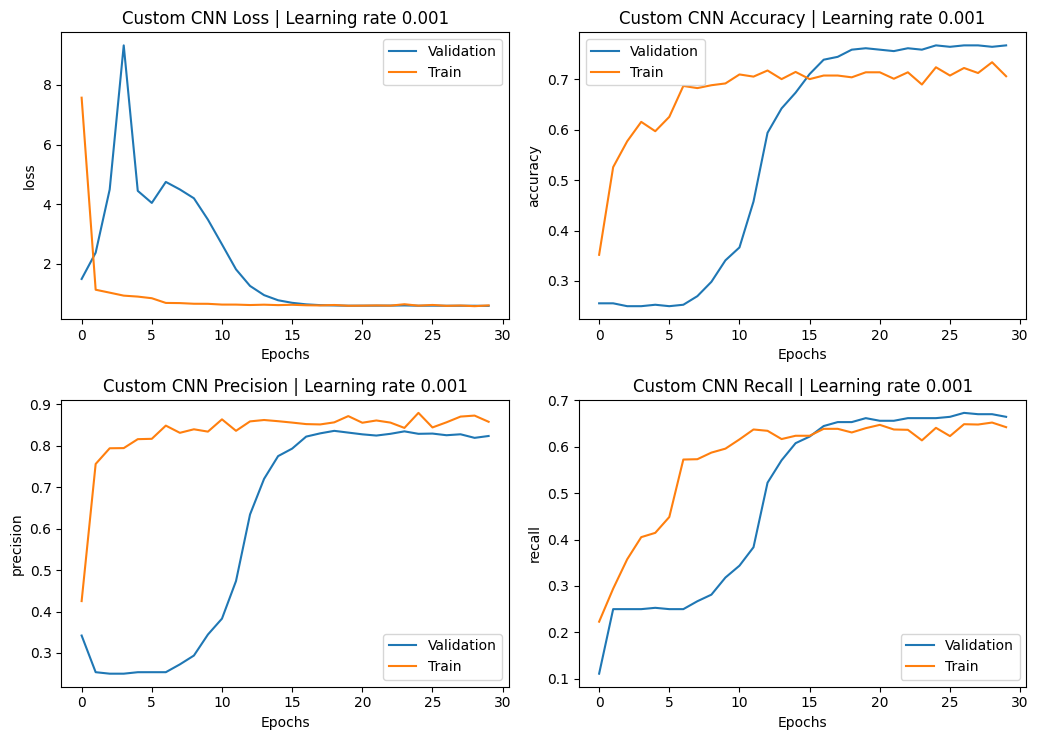

Learning rate: 0.0001
Time: 157.21


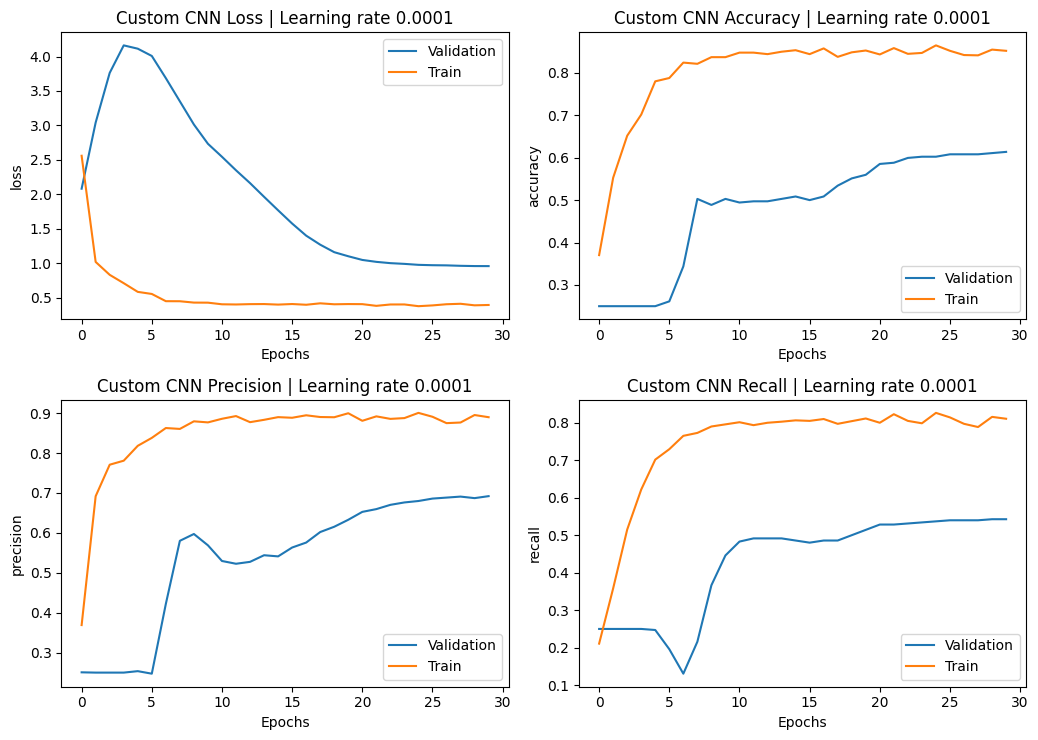

Learning rate: 1e-05
Time: 163.7


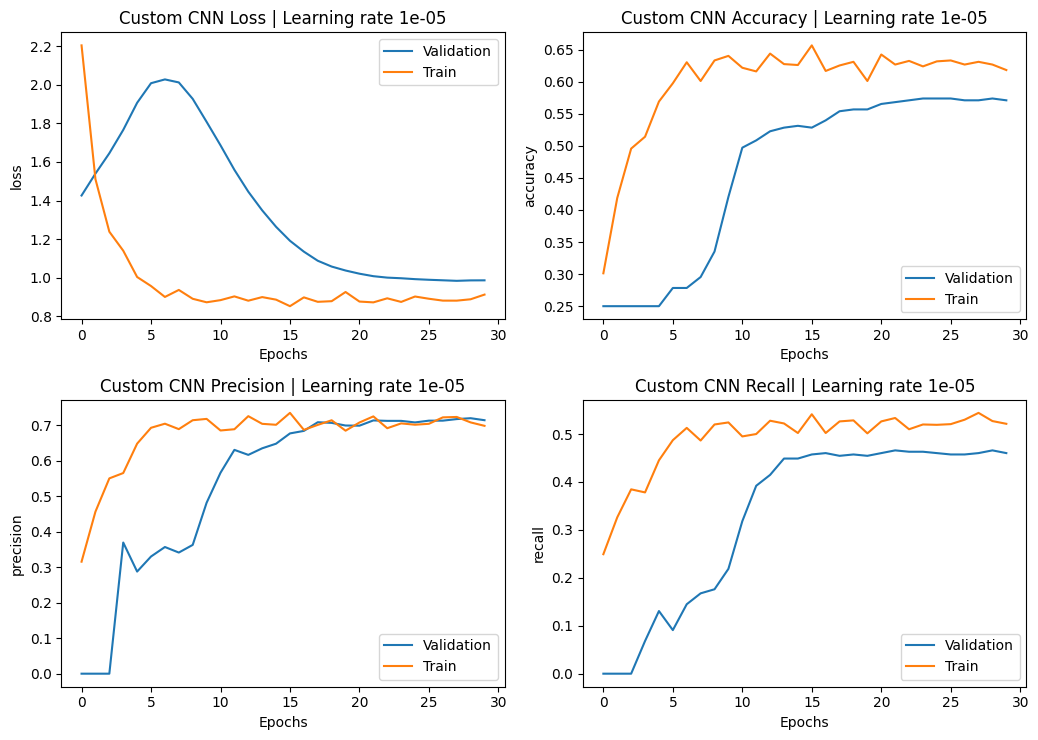

In [38]:
for n,l in enumerate(learning_rates):
  print('Learning rate:',l)
  print('Time:',round(time_custom_cnn[n],2))
  fig,ax=plt.subplots(2,2)
  fig.set_size_inches(10.5, 7.5)
  ax=ax.flatten()
  ax[0].plot(loss_custom_cnn[n],label='Validation')
  ax[0].plot(loss_custom_cnn_train[n],label='Train')
  ax[0].set_title('Custom CNN Loss | Learning rate {f}'.format(f=l))
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('loss')
  ax[0].legend()

  ax[1].plot(accuracy_custom_cnn[n],label='Validation')
  ax[1].plot(accuracy_custom_cnn_train[n],label='Train')
  ax[1].set_title('Custom CNN Accuracy | Learning rate {f}'.format(f=l))
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()

  ax[2].plot(precision_custom_cnn[n],label='Validation')
  ax[2].plot(precision_custom_cnn_train[n],label='Train')
  ax[2].set_title('Custom CNN Precision | Learning rate {f}'.format(f=l))
  ax[2].set_xlabel('Epochs')
  ax[2].set_ylabel('precision')
  ax[2].legend()

  ax[3].plot(recall_custom_cnn[n],label='Validation')
  ax[3].plot(recall_custom_cnn_train[n],label='Train')
  ax[3].set_title('Custom CNN Recall | Learning rate {f}'.format(f=l))
  ax[3].set_xlabel('Epochs')
  ax[3].set_ylabel('recall')
  ax[3].legend()

  plt.tight_layout()
  plt.legend(loc='lower right')
  plt.show()

Learning rate: 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step


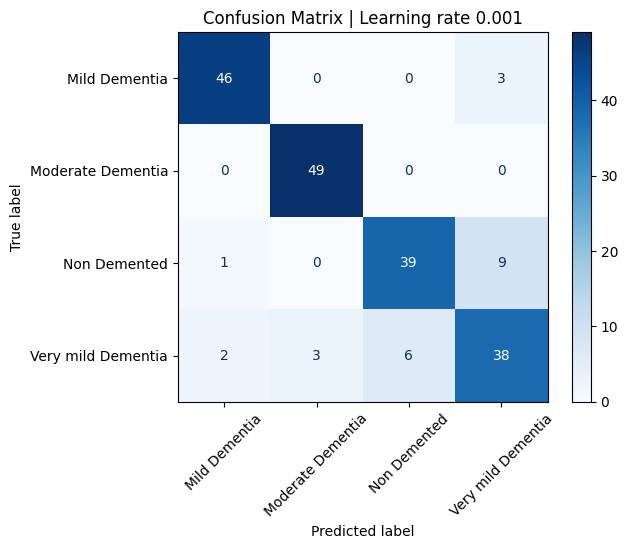

                    precision    recall  f1-score   support

     Mild Dementia       0.94      0.94      0.94        49
 Moderate Dementia       0.94      1.00      0.97        49
      Non Demented       0.87      0.80      0.83        49
Very mild Dementia       0.76      0.78      0.77        49

          accuracy                           0.88       196
         macro avg       0.88      0.88      0.88       196
      weighted avg       0.88      0.88      0.88       196

Learning rate: 0.0001
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


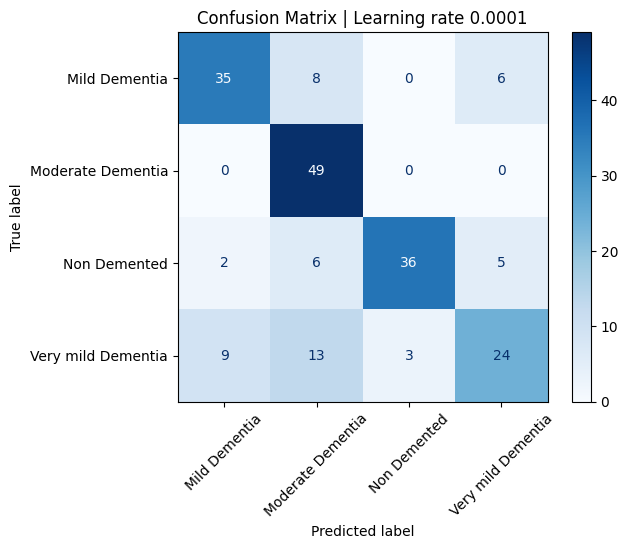

                    precision    recall  f1-score   support

     Mild Dementia       0.76      0.71      0.74        49
 Moderate Dementia       0.64      1.00      0.78        49
      Non Demented       0.92      0.73      0.82        49
Very mild Dementia       0.69      0.49      0.57        49

          accuracy                           0.73       196
         macro avg       0.75      0.73      0.73       196
      weighted avg       0.75      0.73      0.73       196

Learning rate: 1e-05
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


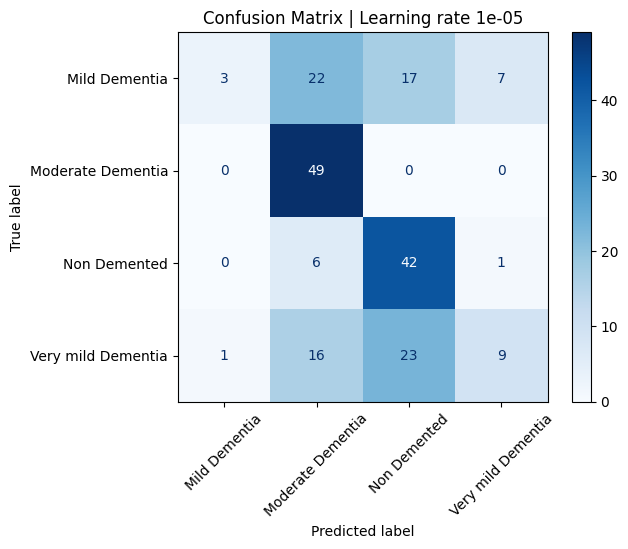

                    precision    recall  f1-score   support

     Mild Dementia       0.75      0.06      0.11        49
 Moderate Dementia       0.53      1.00      0.69        49
      Non Demented       0.51      0.86      0.64        49
Very mild Dementia       0.53      0.18      0.27        49

          accuracy                           0.53       196
         macro avg       0.58      0.53      0.43       196
      weighted avg       0.58      0.53      0.43       196



In [ ]:
for n,i in enumerate(learning_rates):
  print('Learning rate:',i)
  custom_cnn.load_weights('/content/drive/MyDrive/images_MRI/custom_cnn_weights_{l}.keras'.format(l=n))
  custom_cnn_predicted=custom_cnn.predict(data_test/255)
  custom_cnn_predicted=np.argmax(custom_cnn_predicted,axis=1)
  cm=confusion_matrix(np.argmax(label_test,axis=1),custom_cnn_predicted)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix | Learning rate {f}'.format(f=i))
  plt.xticks(rotation=45)
  plt.show()
  print(classification_report(np.argmax(label_test,axis=1),custom_cnn_predicted,target_names=label_encoder.classes_))

### Ensamble model

In [107]:
unet_res.load_weights('/content/drive/MyDrive/images_MRI/unet_res_weights_0.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 238 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [108]:
custom_cnn.load_weights('/content/drive/MyDrive/images_MRI/custom_cnn_weights_0.keras')

In [109]:
ensamble_model=tf.keras.Sequential([
    unet_res,
    custom_cnn
])

In [110]:
ensamble_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ (None, 128, 128, 3)    │    30,374,019 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 4)              │     8,678,692 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,052,711 (148.97 MB)

 Trainable params: 39,034,151 (148.90 MB)

 Non-trainable params: 18,560 (72.50 KB)

In [111]:
ensamble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['accuracy','precision','recall'])

In [112]:
predicted_ensamble=ensamble_model.predict(data_test_classification_processed)
predicted_ensamble=np.argmax(predicted_ensamble,axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 607ms/step


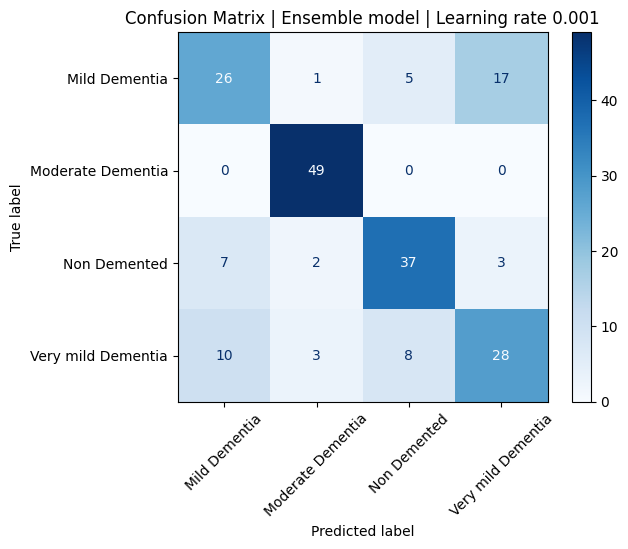

                    precision    recall  f1-score   support

     Mild Dementia       0.60      0.53      0.57        49
 Moderate Dementia       0.89      1.00      0.94        49
      Non Demented       0.74      0.76      0.75        49
Very mild Dementia       0.58      0.57      0.58        49

          accuracy                           0.71       196
         macro avg       0.70      0.71      0.71       196
      weighted avg       0.70      0.71      0.71       196



In [114]:
cm=confusion_matrix(np.argmax(label_test,axis=1),predicted_ensamble)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix | Ensemble model | Learning rate 0.001')
plt.xticks(rotation=45)
plt.show()

print(classification_report(np.argmax(label_test,axis=1),predicted_ensamble,target_names=label_encoder.classes_))